In [1]:
#-----------------------------------------------------------------------------------------------------------------
# Simulation experiment
#
# Network:
# gene set A --> gene set B
#
# Algorithm
# Let gene set A be TF's:
# if genes in set A expression > threshold_A:
#     genes in set B are set to some proportion of the expression of gene A
#
# Apply this algorithm for each sample in the compendium (essentially adding a signal to the existing gene expression data in the compendium)
# 
# Hyperparmeters should include: 
# 1. Size of gene set A
# 2. Size of gene set B
# 3. Proportion of gene A expression
# 4. Thresholds
# 5. Log file with hyperparameter selections
#-----------------------------------------------------------------------------------------------------------------
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import random
import seaborn as sns

from functions import generate_input, vae, def_offset, interpolate, pca, plot

from numpy.random import seed
randomState = 123
seed(randomState)

Using TensorFlow backend.


In [2]:
# Hyperparameters

# Size of the gene set A
geneSetA_size = 100

# Size of the gene set that will be regulated by gene A
geneSetB_size = 1000 

# Percentage to upregulate each gene in set B
effect_size = 0.5

# Threshold for activation of gene A 
thresholdA = 0.5

# Name of analysis
analysis_name = 'sim_AB_2775_300_skewA'

In [3]:
# Load arguments
data_file = os.path.join(os.path.dirname(os.getcwd()), "data", "all-pseudomonas-gene-normalized.zip")

In [4]:
# Read in data
data = pd.read_table(data_file, header=0, sep='\t', index_col=0, compression='zip').T
data.head(5)

Gene_symbol,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA5561,PA5562,PA5563,PA5564,PA5565,PA5566,PA5567,PA5568,PA5569,PA5570
0.1_12hr_CSV86(Pae_G1a).CEL,0.472897,0.396658,0.253776,0.000000,0.175640,0.554385,0.411370,0.382222,0.310144,0.642522,...,0.358597,0.390048,0.457406,0.684082,0.338351,0.608325,0.643496,0.276075,0.112773,0.145170
0.1_2hr_CSV86(Pae_G1a).CEL,0.262346,0.086216,0.359853,0.439214,0.269749,0.768433,0.212505,0.062043,0.567695,0.467073,...,0.358504,0.414206,0.389879,0.477693,0.000000,0.479385,0.154471,0.140891,0.167505,0.157060
0.1_6hr_CSV86(Pae_G1a).CEL,0.473658,0.244862,0.330750,0.097697,0.387226,0.328319,0.228820,0.330039,0.318081,0.512864,...,0.180744,0.380741,0.173501,0.251571,0.182793,0.528301,0.504985,0.499782,0.061106,0.365612
0.1_7hr_CSV86(Pae_G1a).CEL,0.439273,0.343402,0.192698,0.274677,0.628979,0.553796,0.431391,0.363480,0.385721,0.094584,...,0.346837,0.153927,0.067349,0.319723,0.282442,0.490655,0.531415,0.153880,0.132333,0.260087
0.1_9hr_CSV86(Pae_G1a).CEL,0.220827,0.145525,0.437803,0.293201,0.635120,0.462893,0.488733,0.309584,0.318646,0.591914,...,0.237726,0.301945,0.070222,0.513605,0.114277,0.360259,0.386868,0.223995,0.105343,0.102088


In [5]:
# Randomly select genes for set A
gene_ids = list(data.columns)
geneSetA = random.sample(gene_ids, geneSetA_size)

In [6]:
# checkpoint:  Check the number of genes
assert(len(gene_ids)==5549)
print("Confirmed that all gene ids are available")

Confirmed that all gene ids are available


In [7]:
# Remove gene ids that were selected for gene set A
gene_ids = [elem for elem in gene_ids if elem not in geneSetA]
print("After removing {} gene ids for set A, there are {} gene ids remaining.".format(geneSetA_size, len(gene_ids)))

After removing 100 gene ids for set A, there are 5449 gene ids remaining.


In [8]:
# Randomly select genes for gene set B
geneSetB = random.sample(gene_ids, geneSetB_size)

# Remove gene ids that were selected for gene set B
gene_ids = [elem for elem in gene_ids if elem not in geneSetB]
print("After removing {} gene ids for set B, there are {} gene ids remaining.".format(geneSetB_size, len(gene_ids)))

After removing 1000 gene ids for set B, there are 4449 gene ids remaining.


In [9]:
# checkpoint:  Check that genes in set A are distinct from genes in set B
assert(len(set(geneSetA).intersection(set(geneSetB))) == 0)

In [10]:
# Main input data simulation 

# Loop through all samples
num_samples = data.shape[1]
for sample_id in data.index:
    row = data.loc[sample_id]
    
    # Randomly select a value [0,1] where each value is uniformly likely to be chosen
    new_A_exp = random.uniform(0.4, 1.0)
    
    # Set gene expression value for genes in set A to be the same random value selected
    data.loc[sample_id][geneSetA] = new_A_exp
    
    # Select sample gene from set A to be representative since the expression is the same
    # for all genes in the set
    geneSetA_pick = geneSetA[0]
    
    # Check if expression of genes in set A exceed the threshold
    if data.loc[sample_id,geneSetA_pick] > thresholdA:
        
        # Scale genes by some fixed percentage
        for gene in geneSetB:
            data.loc[sample_id,gene] = (1+effect_size)*data.loc[sample_id,gene]            
            
# if any exceed 1 then set to 1 since gene expression is normalized
data[data>=1.0] = 1.0

In [11]:
# Dataframe with only genes in set A
geneA_only = pd.DataFrame(data[geneSetA_pick], index=data.index, columns=[geneSetA_pick])

# Drop genes in set A
data_holdout = data.drop(geneSetA, axis=1)

geneA_only

,PA3423
0.1_12hr_CSV86(Pae_G1a).CEL,0.650642
0.1_2hr_CSV86(Pae_G1a).CEL,0.988583
0.1_6hr_CSV86(Pae_G1a).CEL,0.454484
0.1_7hr_CSV86(Pae_G1a).CEL,0.902638
0.1_9hr_CSV86(Pae_G1a).CEL,0.910483
05_PA14000-4-2_5-10-07_S2.CEL,0.551351
1_12hr_CSV86(Pae_G1a).CEL,0.566099
1_2hr_CSV86(Pae_G1a).CEL,0.563180
1_6hr_CSV86(Pae_G1a).CEL,0.481958
1_7hr_CSV86(Pae_G1a).CEL,0.886663


In [12]:
# checkpoint:  Check that the holdout set does not include genes in set A
assert(data_holdout.shape[1] == (data.shape[1]-len(geneSetA)))
print("Confirmed that holdout set is the correct size")

Confirmed that holdout set is the correct size


In [13]:
# Create list of base directories
base_dirs = [os.path.join(os.path.dirname(os.getcwd()), 'data'),
             os.path.join(os.path.dirname(os.getcwd()), 'encoded'),
             os.path.join(os.path.dirname(os.getcwd()), 'models'),
             os.path.join(os.path.dirname(os.getcwd()), 'output'),
             os.path.join(os.path.dirname(os.getcwd()), 'stats'),
             os.path.join(os.path.dirname(os.getcwd()), 'viz')    
]

# Check if directory exist otherwise create
for each_dir in base_dirs:
    analysis_dir = os.path.join(each_dir, analysis_name)
    if os.path.exists(analysis_dir):
        print('directory already exists: {}'.format(analysis_dir))
    else:
        os.mkdir(analysis_dir)
        print('creating new directory: {}'.format(analysis_dir))

creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/data/sim_AB_2775_300_skewA
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/encoded/sim_AB_2775_300_skewA
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/models/sim_AB_2775_300_skewA
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/output/sim_AB_2775_300_skewA
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/stats/sim_AB_2775_300_skewA
creating new directory: /home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/viz/sim_AB_2775_300_skewA


In [14]:
# Output the new gene expression values for each sample
train_input_file = os.path.join(base_dirs[0], analysis_name, "train_model_input.txt.xz")
data_holdout.to_csv(train_input_file, sep='\t', compression='xz', float_format="%.5g")

# Output log file with params
log_file = os.path.join(os.path.dirname(os.getcwd()), 'metadata', analysis_name + '.txt')

args_dict = {
    "size of gene set A": geneSetA_size,
    "size of gene set B": geneSetB_size,
    "genes in set B": geneSetB,
    "effect size of genes in set B": effect_size,
    "threshold of A activation": thresholdA,
}

with open(log_file, 'w') as f:
    for key, value in args_dict.items():
        f.write('%s: %s\n' % (key, value))
        
# Output geneA only file using sample gene A selected
geneA_file = os.path.join(base_dirs[0], analysis_name, geneSetA_pick + ".txt")
geneA_only.to_csv(geneA_file, sep='\t', float_format="%.5g")

/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/vae.py:206: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  vae.compile(optimizer=adam, loss=None, loss_weights=[beta])


Train on 1072 samples, validate on 119 samples
Epoch 1/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3548.5206 - val_loss: 3842.0600
Epoch 2/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3378.3749 - val_loss: 3497.1759
Epoch 3/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3337.4994 - val_loss: 3410.7854
Epoch 4/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3311.0915 - val_loss: 3362.2109
Epoch 5/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3292.5178 - val_loss: 3344.1923
Epoch 6/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3277.0648 - val_loss: 3319.0569
Epoch 7/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3269.1627 - val_loss: 3294.9519
Epoch 8/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3260.7890 - val_loss: 3290.1356
Epoch 9/200
1072/1072 [==============================] - 12s 11ms

Epoch 74/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3129.7898 - val_loss: 3181.9069
Epoch 75/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3128.7804 - val_loss: 3181.7753
Epoch 76/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3128.6406 - val_loss: 3180.2766
Epoch 77/200
1072/1072 [==============================] - 12s 12ms/step - loss: 3128.0130 - val_loss: 3179.5845
Epoch 78/200
1072/1072 [==============================] - 13s 12ms/step - loss: 3127.5329 - val_loss: 3178.2323
Epoch 79/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3127.2682 - val_loss: 3177.1810
Epoch 80/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3126.4546 - val_loss: 3181.1202
Epoch 81/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3126.0289 - val_loss: 3177.4901
Epoch 82/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3125.5302 - val_loss: 31

1072/1072 [==============================] - 12s 11ms/step - loss: 3105.1664 - val_loss: 3172.7499
Epoch 147/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3105.2445 - val_loss: 3174.6016
Epoch 148/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3105.2472 - val_loss: 3173.5426
Epoch 149/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3105.0712 - val_loss: 3173.8249
Epoch 150/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3105.3595 - val_loss: 3175.6049
Epoch 151/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3104.8731 - val_loss: 3172.4727
Epoch 152/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3104.3225 - val_loss: 3174.2366
Epoch 153/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3103.7540 - val_loss: 3175.5240
Epoch 154/200
1072/1072 [==============================] - 12s 11ms/step - loss: 3104.4852 - val_loss: 3174.93

/home/alexandra/anaconda3/envs/Pa/lib/python3.5/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Number of genes in low expression group is (60, 5449)
Number of gene in high expression group is (60, 5449)
Number of genes in low expression group is (60, 5449)
Number of gene in high expression group is (60, 5449)


/home/alexandra/Documents/Repos/Pseudomonas_latent_spaces/scripts/functions/plot.py:87: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  X_sorted = X.loc[sorted_id.index].dropna()


CPU times: user 37min, sys: 4min 30s, total: 41min 31s
Wall time: 41min 10s


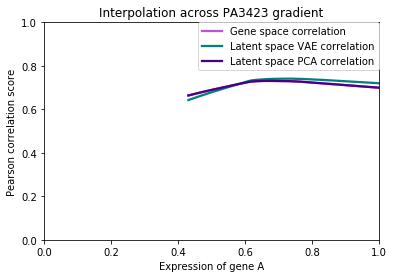

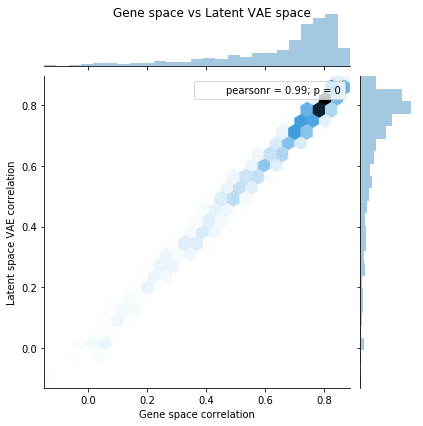

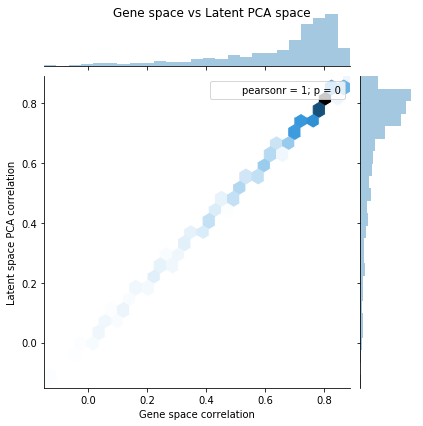

In [15]:
%%time
# Train models on input dataset

# params
learning_rate = 0.001
batch_size = 100
epochs = 200
kappa = 0.01
intermediate_dim = 2775
latent_dim = 300
epsilon_std = 1.0
num_PCs = latent_dim

base_dir = os.path.dirname(os.getcwd())
vae.tybalt_2layer_model(learning_rate, batch_size, epochs, kappa, intermediate_dim,
                        latent_dim, epsilon_std, base_dir, analysis_name)
pca.pca_model(base_dir, analysis_name, num_PCs)


# Define offset vectors in gene space
data_dir = os.path.join(base_dirs[0], analysis_name)
target_gene = geneSetA_pick
percent_low = 5
percent_high = 95

def_offset.gene_space_offset(data_dir, target_gene, percent_low, percent_high)


# Define offset vectors for different latent spaces
model_dir = os.path.join(base_dirs[2], analysis_name)
encoded_dir = os.path.join(base_dirs[1], analysis_name)

def_offset.vae_latent_space_offset(data_dir, model_dir, encoded_dir, latent_dim, target_gene, percent_low, percent_high)
def_offset.pca_latent_space_offset(data_dir, model_dir, encoded_dir, target_gene, percent_low, percent_high)


# Predict gene expression using offset in gene space and latent space
out_dir = os.path.join(base_dirs[3], analysis_name)

interpolate.interpolate_in_gene_space(data_dir, target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_vae_latent_space(data_dir, model_dir, encoded_dir, latent_dim, 
                                            target_gene, out_dir, percent_low, percent_high)
interpolate.interpolate_in_pca_latent_space(data_dir, model_dir, encoded_dir, target_gene, out_dir, percent_low, percent_high)

# True if the x-axis of the plot uses the sample index
# False if the x-asix of the plot uses the gene expression of the target gene
by_sample_ind = False

# Plot prediction per sample along gradient of PA1673 expression
viz_dir = os.path.join(base_dirs[5], analysis_name)
plot.plot_corr_gradient(out_dir, viz_dir, target_gene, by_sample_ind)